In [2]:
# %%

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import silhouette_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import GridSearchCV
import shap
import warnings
warnings.filterwarnings('ignore')
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Set style for plots
#plt.style.use('seaborn')
sns.set_theme(style="darkgrid")
sns.set_palette("husl")

In [3]:
# %%

# Load and explore the data
df = pd.read_csv('/content/africa_stock_5yrs.csv')
print("Data shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nData info:")
print(df.info())
print("\nBasic statistics:")
print(df.describe())

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

Data shape: (16320, 7)

First few rows:
         date         open         high          low        close  \
0  2019-01-02     0.074821     0.074821     0.074821     0.074821   
1  2019-01-02  1258.914428  1281.118359  1242.313359  1261.404589   
2  2019-01-02     0.225049     0.225049     0.217221     0.217710   
3  2019-01-02     0.605863     0.605863     0.605863     0.605863   
4  2019-01-02  1220.870311  1233.597798  1199.358092  1214.852423   

        volume        Name  
0  18026840.08  ZENITHBANK  
1    702532.00         ANG  
2   1778300.00        SCOM  
3    178423.00     DANGCEM  
4   1650877.00         SBK  

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16320 entries, 0 to 16319
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    16320 non-null  object 
 1   open    16320 non-null  float64
 2   high    16320 non-null  float64
 3   low     16320 non-null  float64
 4   close   16320 non-null  

In [4]:
# %%

# Feature Engineering
def create_features(df):
    # Technical indicators
    df['daily_return'] = df.groupby('Name')['close'].pct_change()
    df['volatility'] = df.groupby('Name')['daily_return'].rolling(window=20).std().reset_index(0, drop=True)
    df['moving_avg_20'] = df.groupby('Name')['close'].rolling(window=20).mean().reset_index(0, drop=True)
    df['moving_avg_50'] = df.groupby('Name')['close'].rolling(window=50).mean().reset_index(0, drop=True)

    # Price momentum
    df['momentum'] = df.groupby('Name')['close'].pct_change(periods=5)

    # Volume features
    df['volume_ma'] = df.groupby('Name')['volume'].rolling(window=20).mean().reset_index(0, drop=True)
    df['volume_std'] = df.groupby('Name')['volume'].rolling(window=20).std().reset_index(0, drop=True)

    # Price range features
    df['price_range'] = (df['high'] - df['low']) / df['low']
    df['price_range_ma'] = df.groupby('Name')['price_range'].rolling(window=20).mean().reset_index(0, drop=True)

    return df

df = create_features(df)
df = df.dropna()

In [5]:
# %%

# Log Transformations of Various Features
df['log_close'] = np.log1p(df['close'])
df['log_volume'] = np.log1p(df['volume'])
df['log_open'] = np.log1p(df['open'])
df['log_high'] = np.log1p(df['high'])
df['log_low'] = np.log1p(df['low'])

In [43]:
# Hierarchical Clustering Analysis

# Use log-transformed closing prices
price_data = df.pivot(index='date', columns='Name', values='log_close')
price_data = price_data.fillna(method='ffill')  # Forward fill missing values

In [39]:
price_data.head()

Name,ANG,DANGCEM,GTCO,MTN,MTNN,NB,NPN,SBK,SCOM,SOL,ZENITHBANK
date,,,,,,,,,,,
2019-03-12,7.157575,0.491086,0.109780,6.496465,NaN,0.166868,9.559681,7.180026,0.237700,7.990031,0.070872
2019-03-13,7.173899,0.487078,0.110365,6.504675,NaN,0.166868,9.565695,7.160195,0.236625,7.985874,0.070415
2019-03-14,7.175427,0.483091,0.109497,6.474434,NaN,0.166883,9.551794,7.155166,0.238592,8.008332,0.069812
2019-03-15,7.225866,0.483053,0.109487,6.492563,NaN,0.166868,9.561003,7.191349,0.244363,7.987750,0.069195
2019-03-18,7.229036,0.482852,0.109487,6.482198,NaN,0.166868,9.585754,7.200837,0.249325,8.013623,0.068890


In [44]:
# Standardize the data
scaler = StandardScaler()
price_data_scaled = scaler.fit_transform(price_data)



In [45]:
# Standardize the data
scaler = StandardScaler()
price_data_scaled = scaler.fit_transform(price_data)

# Replace infinite values with NaN
price_data_scaled = np.nan_to_num(price_data_scaled)

# Replace NaN values with the mean of each column
col_means = np.nanmean(price_data_scaled, axis=0)
inds = np.where(np.isnan(price_data_scaled))
price_data_scaled[inds] = np.take(col_means, inds[1])

In [46]:
price_data_scaled.shape

(1484, 11)

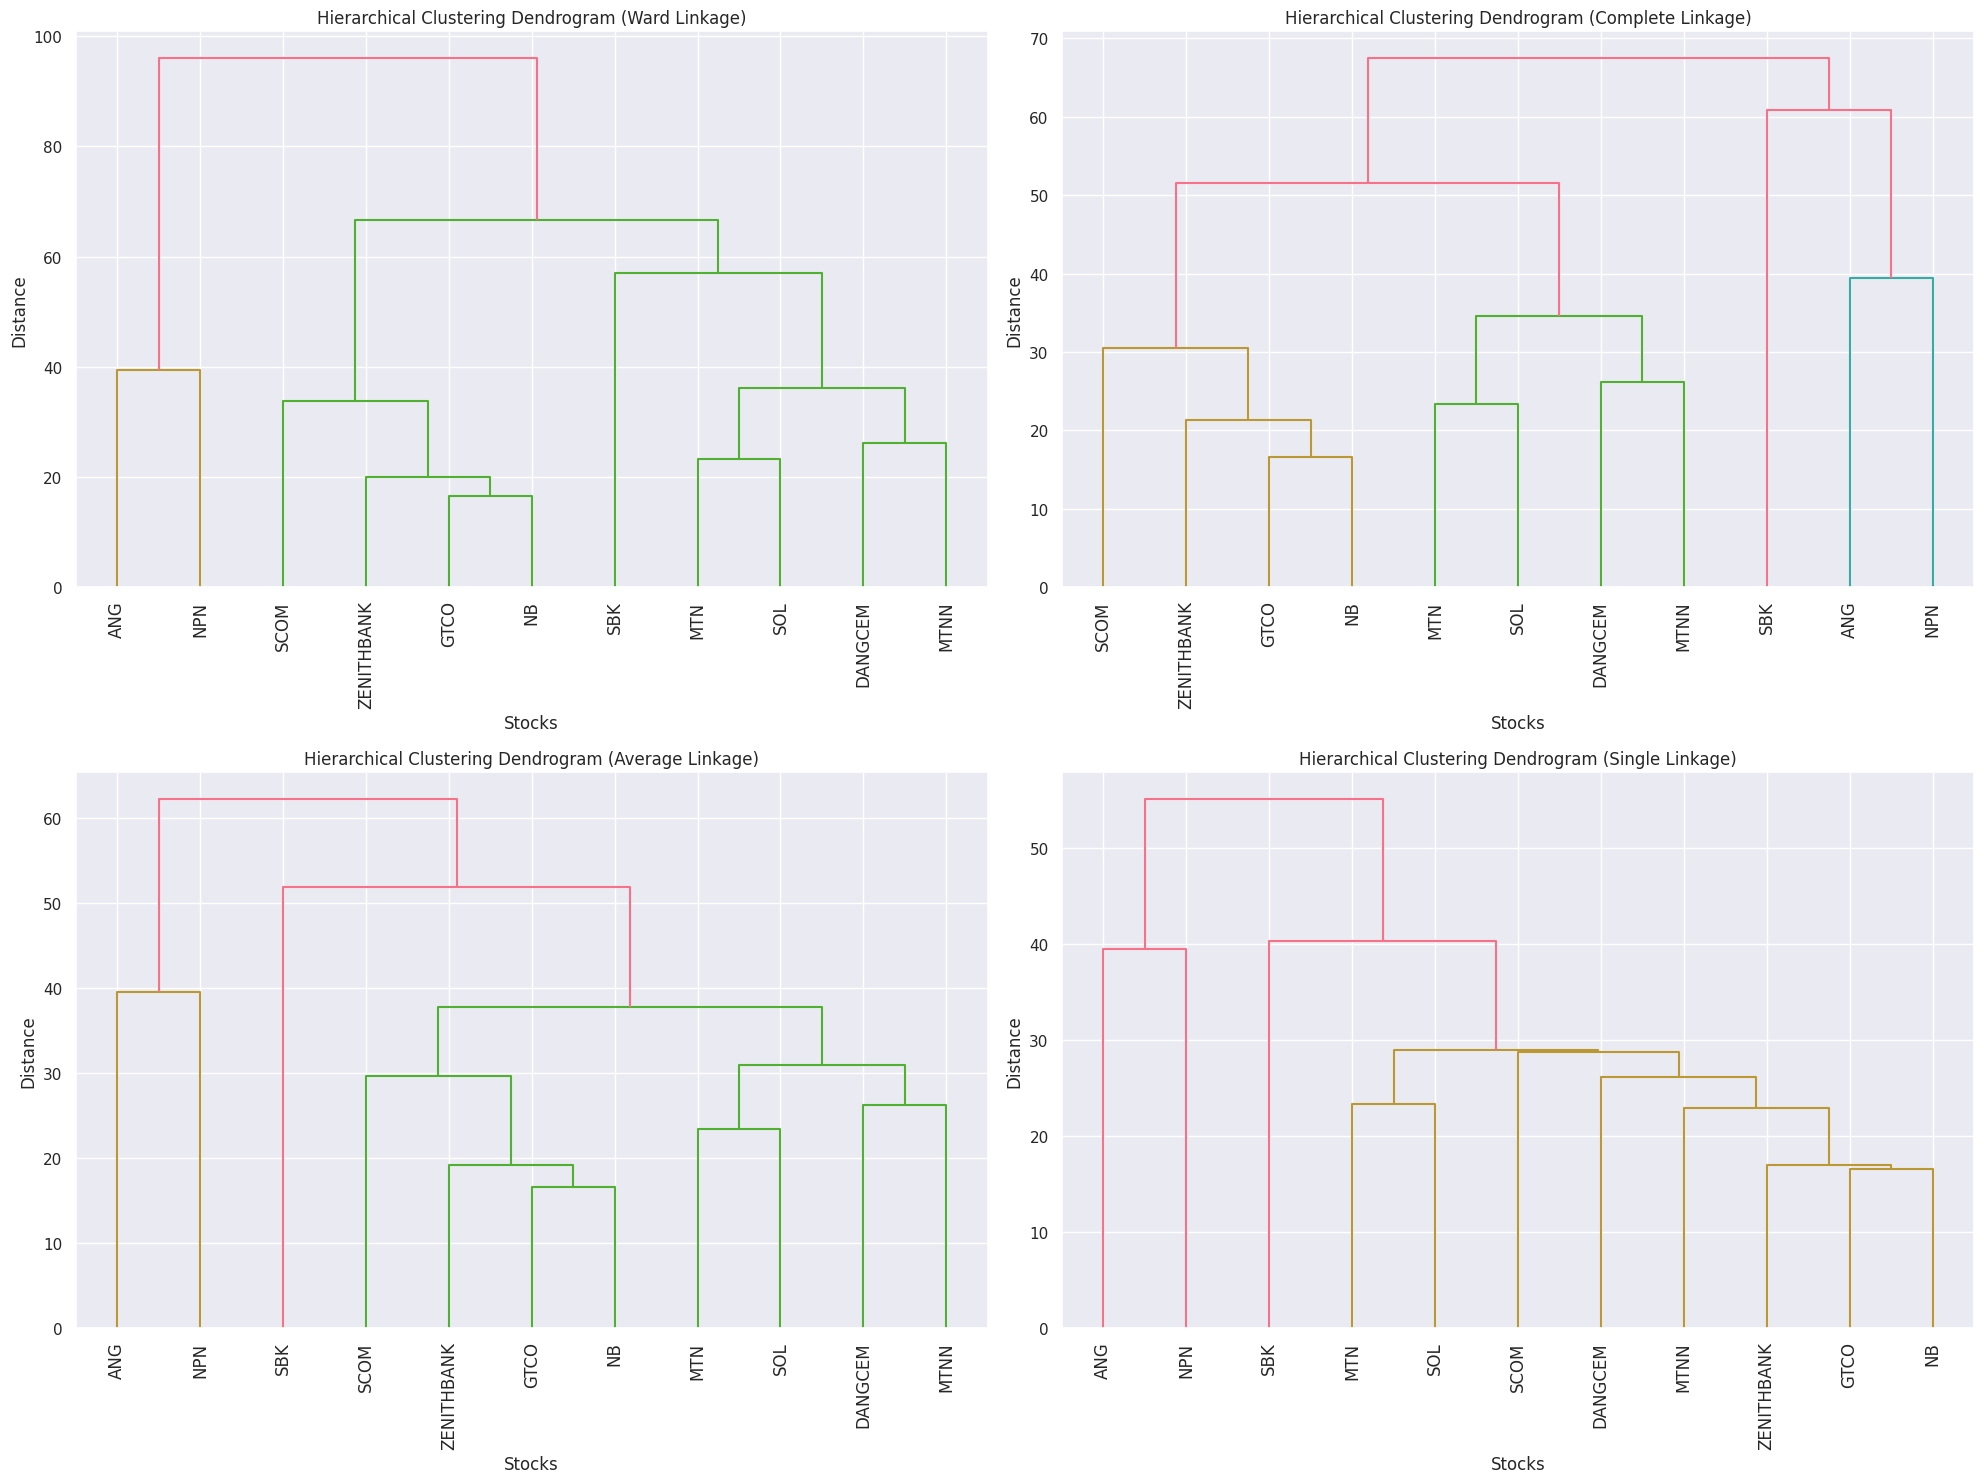

In [47]:
# Perform hierarchical clustering
# Try different linkage methods
linkage_methods = ['ward', 'complete', 'average', 'single']
plt.figure(figsize=(20, 15))

for i, method in enumerate(linkage_methods, 1):
    plt.subplot(2, 2, i)
    Z = linkage(price_data_scaled.T, method=method)
    # Pass the columns of the original price_data DataFrame as labels
    dendrogram(Z, labels=price_data.columns, leaf_rotation=90)
    plt.title(f'Hierarchical Clustering Dendrogram ({method.capitalize()} Linkage)')
    plt.xlabel('Stocks')
    plt.ylabel('Distance')

plt.tight_layout()
plt.show()

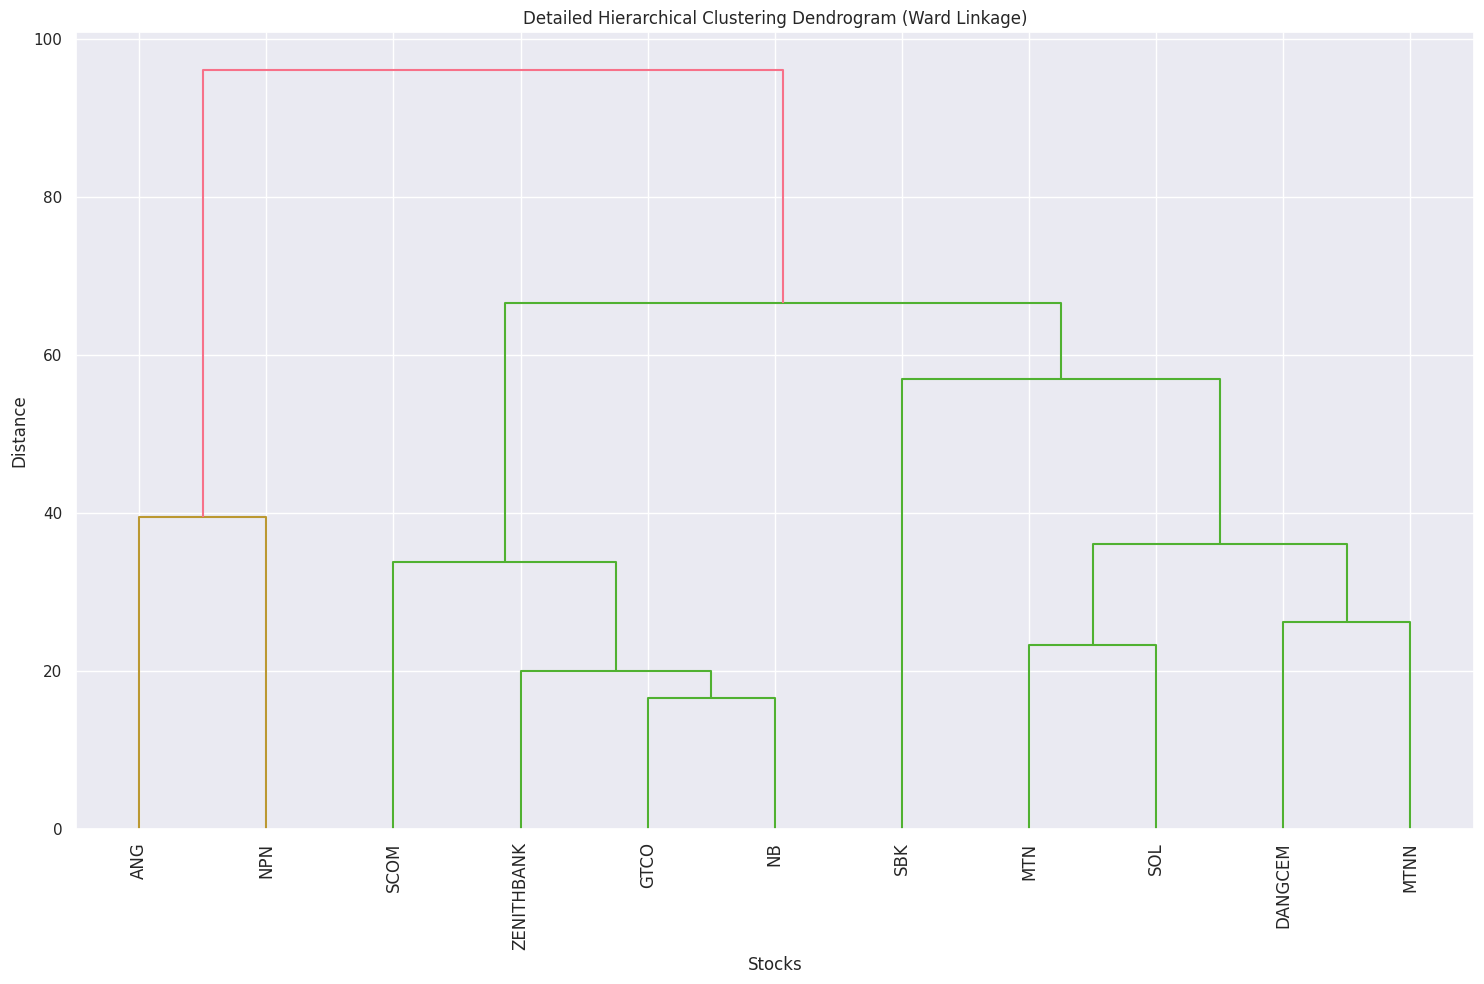

In [48]:
# Choose the best linkage method
best_method = 'ward'
Z = linkage(price_data_scaled.T, method=best_method)

# Plot a more detailed dendrogram
plt.figure(figsize=(15, 10))
dendrogram(Z, labels=price_data.columns, leaf_rotation=90,
          truncate_mode='level', p=5)
plt.title('Detailed Hierarchical Clustering Dendrogram (Ward Linkage)')
plt.xlabel('Stocks')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()



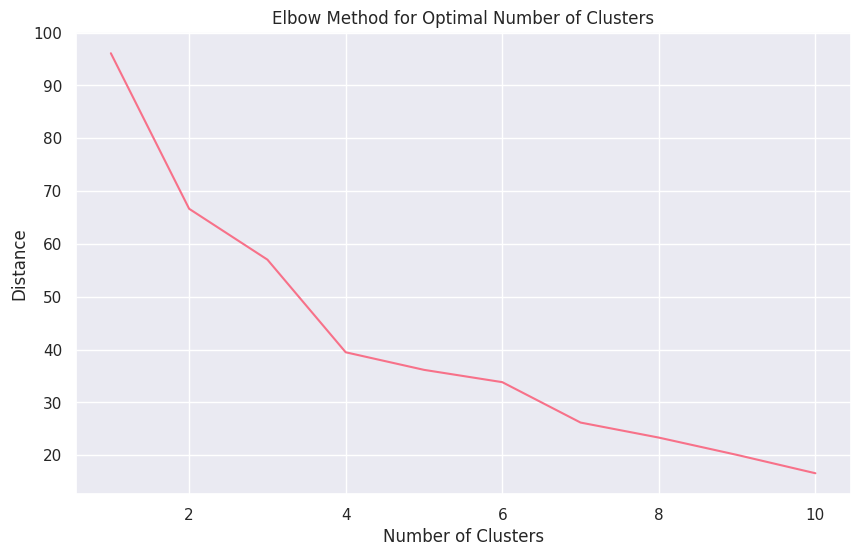

In [49]:
# Determine optimal number of clusters using elbow method
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.figure(figsize=(10, 6))
plt.plot(idxs, last_rev)
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Distance')
plt.grid(True)
plt.show()



In [50]:
# Choose number of clusters
n_clusters = 4
clusters = fcluster(Z, n_clusters, criterion='maxclust')

# Create a DataFrame with cluster assignments
cluster_df = pd.DataFrame({
    'Stock': price_data.columns,
    'Cluster': clusters
})



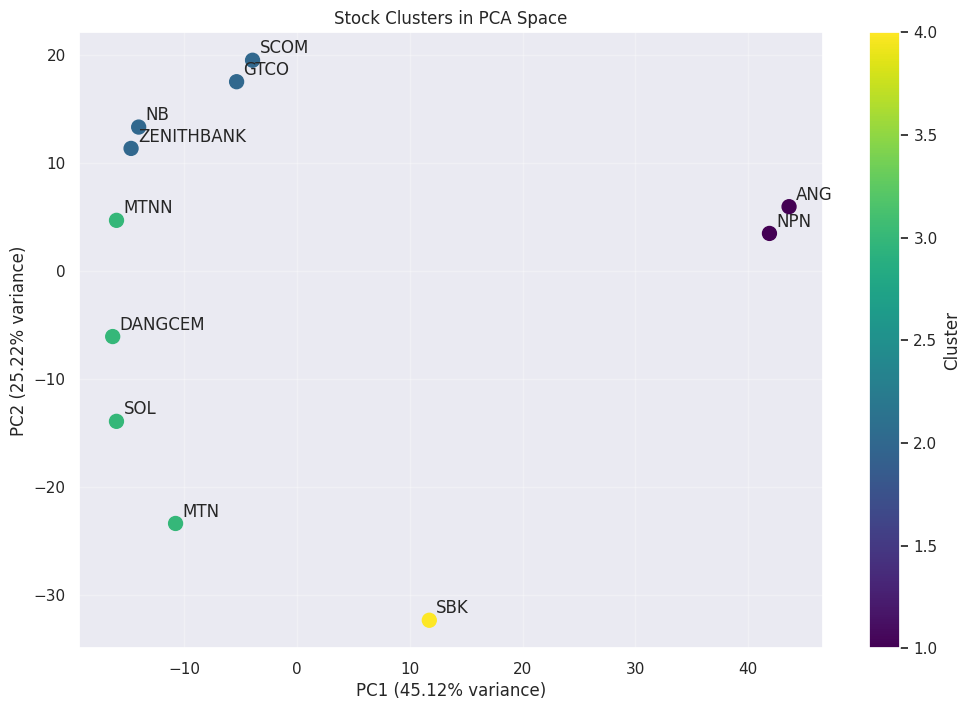

In [51]:
# Visualize clusters in PCA space
pca = PCA(n_components=2)
price_pca = pca.fit_transform(price_data_scaled.T)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(price_pca[:, 0], price_pca[:, 1], c=clusters, cmap='viridis', s=100)
plt.colorbar(scatter, label='Cluster')

# Add stock labels
for i, stock in enumerate(price_data.columns):
    plt.annotate(stock, (price_pca[i, 0], price_pca[i, 1]),
                 xytext=(5, 5), textcoords='offset points')

plt.title('Stock Clusters in PCA Space')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.grid(True, alpha=0.3)
plt.show()



In [53]:
# Analyze cluster characteristics
cluster_stats = pd.DataFrame()
for cluster in range(1, n_clusters + 1):
    cluster_stocks = cluster_df[cluster_df['Cluster'] == cluster]['Stock']
    cluster_data = price_data[cluster_stocks]

    # Calculate statistics
    stats = {
        'Mean Return': cluster_data.mean().mean(),
        'Volatility': cluster_data.std().mean(),
        'Size': len(cluster_stocks),
        'Stocks': ', '.join(cluster_stocks)
    }
    cluster_stats[f'Cluster {cluster}'] = pd.Series(stats)

print("\nCluster Characteristics:")
cluster_stats




Cluster Characteristics:


,Cluster 1,Cluster 2,Cluster 3,Cluster 4
Mean Return,8.686083,0.098557,3.574959,6.881565
Volatility,0.209526,0.036611,0.26611,0.222349
Size,2,4,4,1
Stocks,"ANG, NPN","GTCO, NB, SCOM, ZENITHBANK","DANGCEM, MTN, MTNN, SOL",SBK


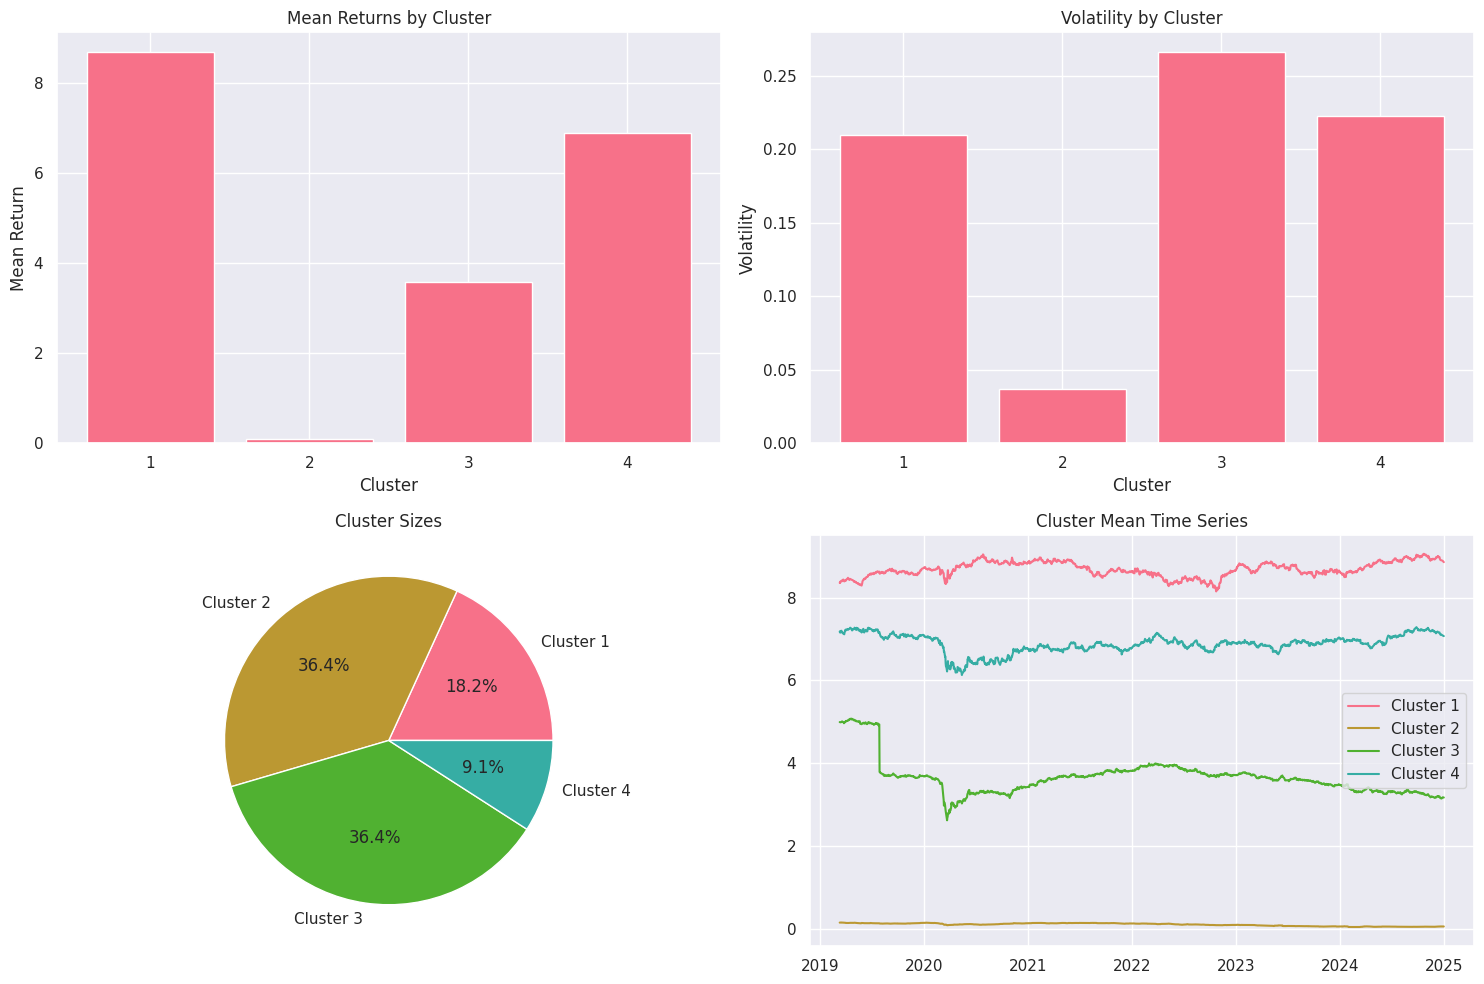

In [56]:
# Visualize cluster characteristics
plt.figure(figsize=(15, 10))

# Plot 1: Mean Returns by Cluster
plt.subplot(2, 2, 1)
cluster_returns = [price_data[cluster_df[cluster_df['Cluster'] == i]['Stock']].mean().mean()
                  for i in range(1, n_clusters + 1)]
plt.bar(range(1, n_clusters + 1), cluster_returns)
plt.title('Mean Returns by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Mean Return')
plt.xticks(range(1, n_clusters + 1))

# Plot 2: Volatility by Cluster
plt.subplot(2, 2, 2)
cluster_vol = [price_data[cluster_df[cluster_df['Cluster'] == i]['Stock']].std().mean()
               for i in range(1, n_clusters + 1)]
plt.bar(range(1, n_clusters + 1), cluster_vol)
plt.title('Volatility by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Volatility')
plt.xticks(range(1, n_clusters + 1))

# Plot 3: Cluster Sizes
plt.subplot(2, 2, 3)
cluster_sizes = [len(cluster_df[cluster_df['Cluster'] == i]) for i in range(1, n_clusters + 1)]
plt.pie(cluster_sizes, labels=[f'Cluster {i}' for i in range(1, n_clusters + 1)],
        autopct='%1.1f%%')
plt.title('Cluster Sizes')

# Plot 4: Time Series of Cluster Means
plt.subplot(2, 2, 4)
for cluster in range(1, n_clusters + 1):
    cluster_stocks = cluster_df[cluster_df['Cluster'] == cluster]['Stock']
    cluster_mean = price_data[cluster_stocks].mean(axis=1)
    plt.plot(cluster_mean, label=f'Cluster {cluster}')
plt.title('Cluster Mean Time Series')
plt.legend()

plt.tight_layout()
plt.show()



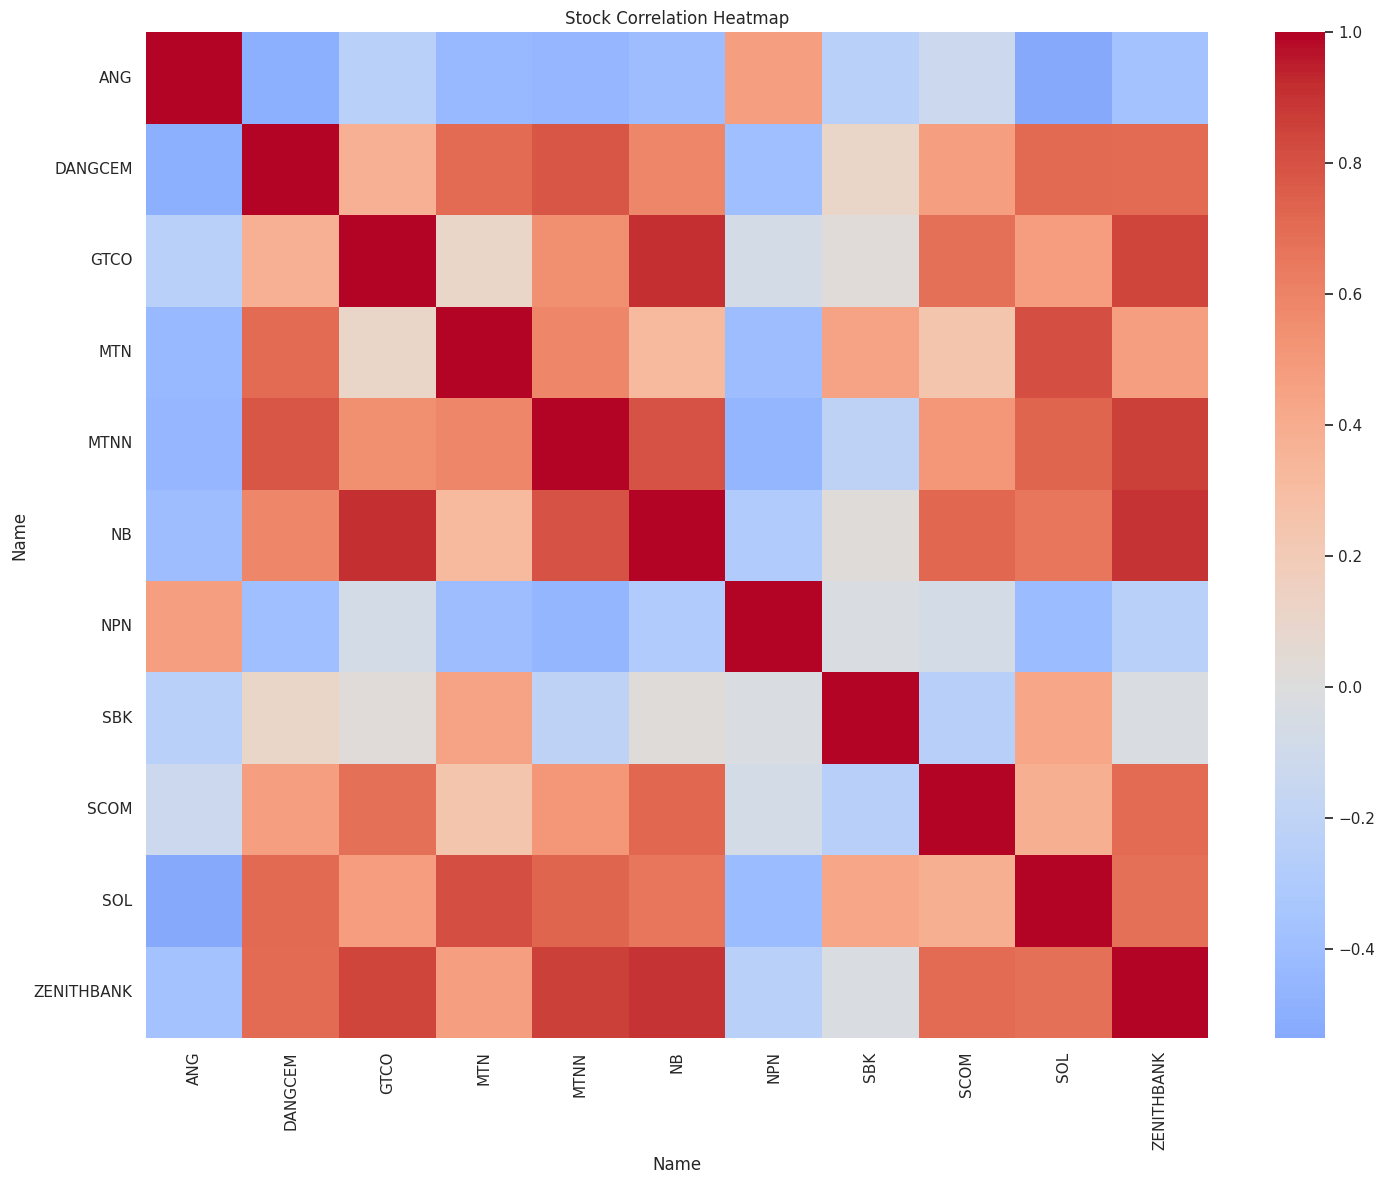

In [57]:
# Create a heatmap of stock correlations within clusters
plt.figure(figsize=(15, 12))
correlation_matrix = price_data.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0,
            xticklabels=True, yticklabels=True)
plt.title('Stock Correlation Heatmap')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()